In [3]:
%pip install osmnx --quiet
%pip install networkx --quiet
%pip install pandana --quiet
%pip install geopandas --quiet
%pip install matplotlib --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Select city and crs
cityname = 'Yogyakarta, Indonesia'
crs = 32749

In [3]:
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [4]:
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'restaurant',
        'university'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
    ],
    'leisure':[
        'park'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags)

# Project pois
pois = pois.to_crs(epsg=crs)

/tmp/ipykernel_23514/2704930940.py:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  pois = ox.geometries.geometries_from_place(cityname, tags=tags)


In [5]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'],
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 185279
Setting CH edge vector of size 481212
Range graph removed 483618 edges of 962424
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [7]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x,
    y_col=centroids.y
)

In [8]:
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
275838150,147,332,662,810,900,900,900,900,900,900
7357532847,59,421,574,722,900,900,900,900,900,900
6811507285,162,318,677,825,900,900,900,900,900,900
8477877404,398,583,900,900,900,900,900,900,900,900
275838539,900,900,900,900,900,900,900,900,900,900


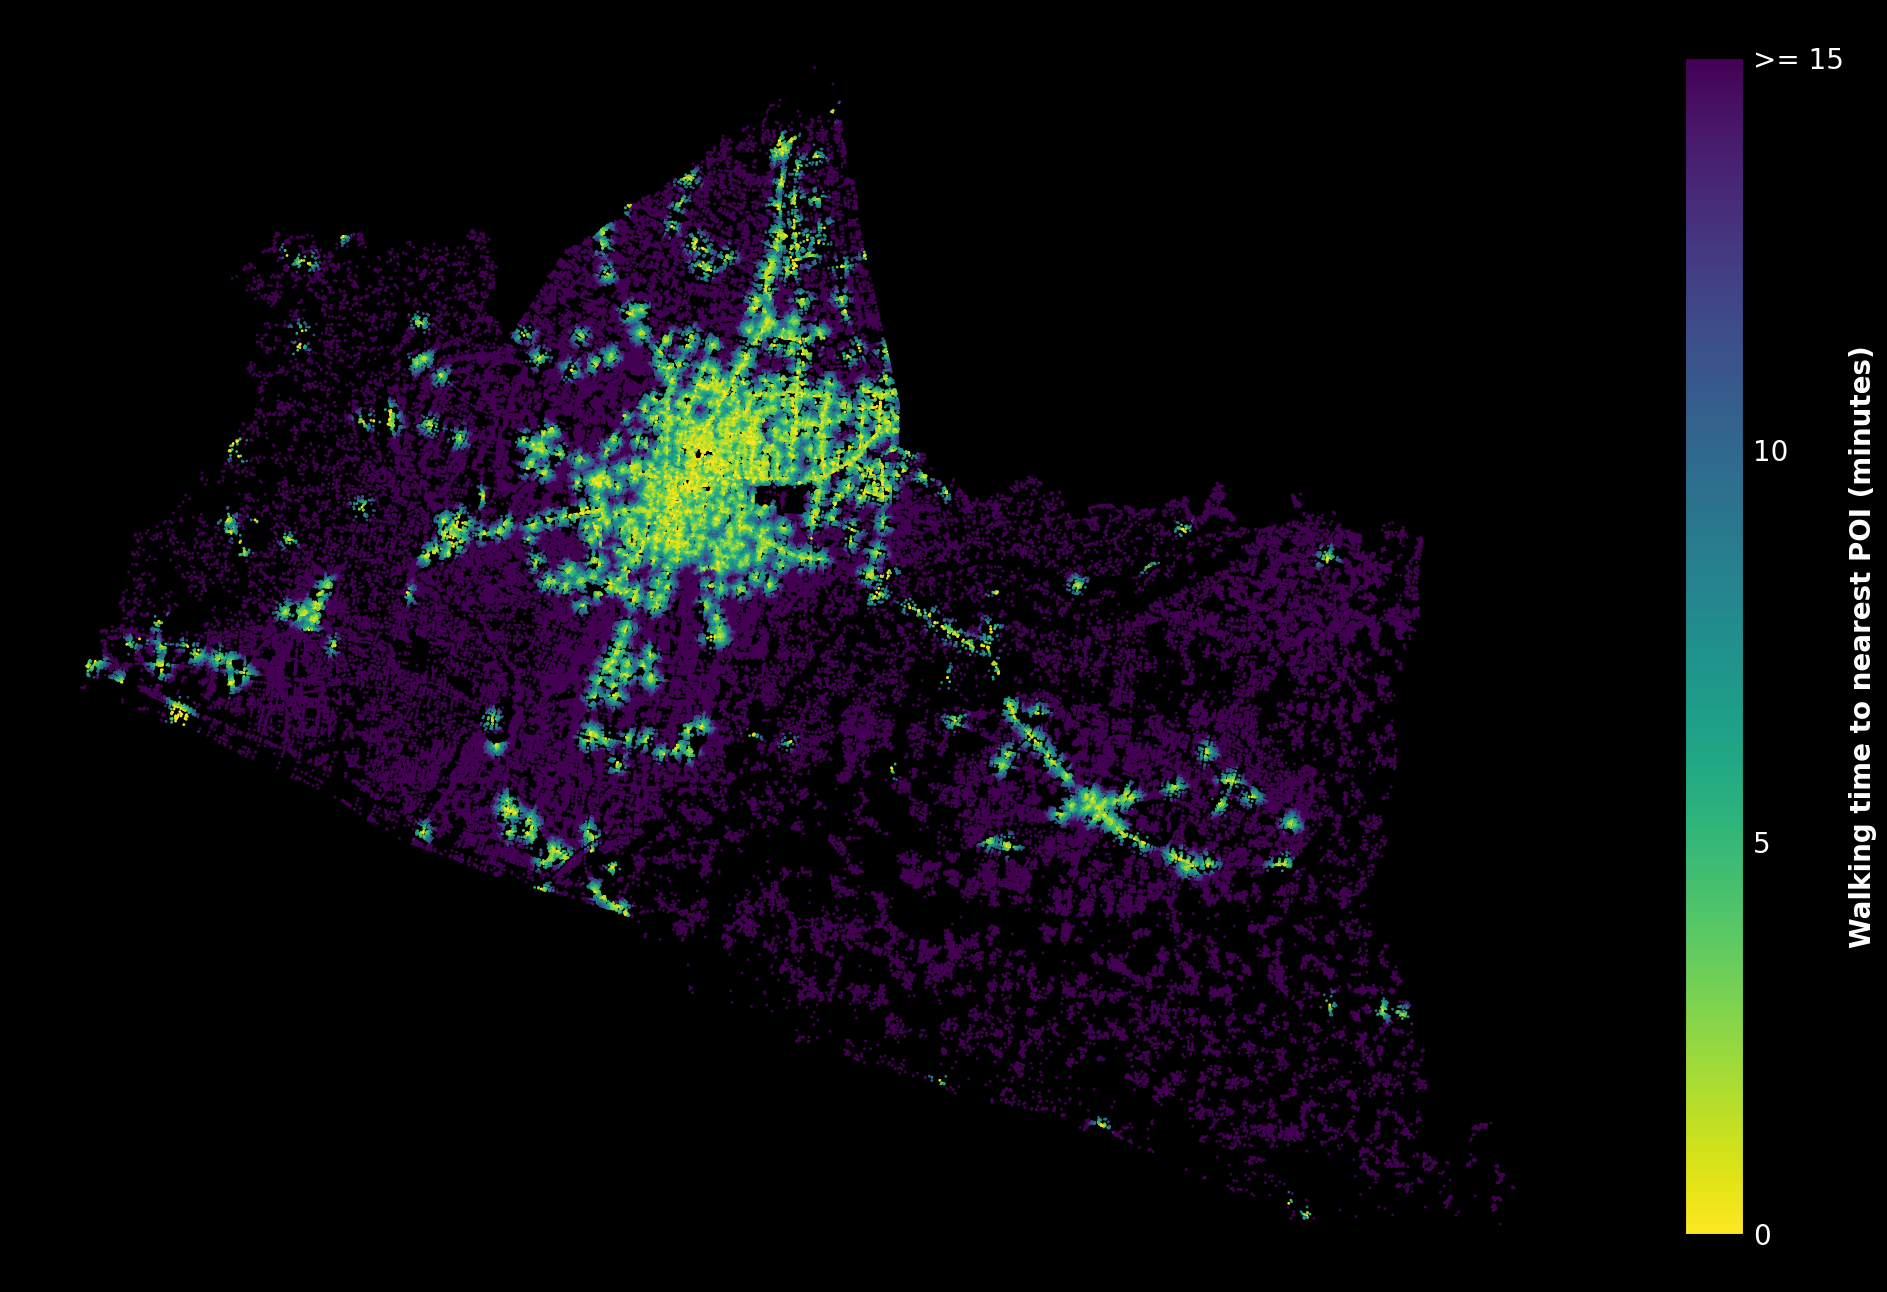

In [9]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'],
    c=distances[1],
    s=1,
    cmap='viridis_r',
)

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

# Save
# plt.savefig('./docs/walk_access.png')

/tmp/ipykernel_23514/1720226244.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


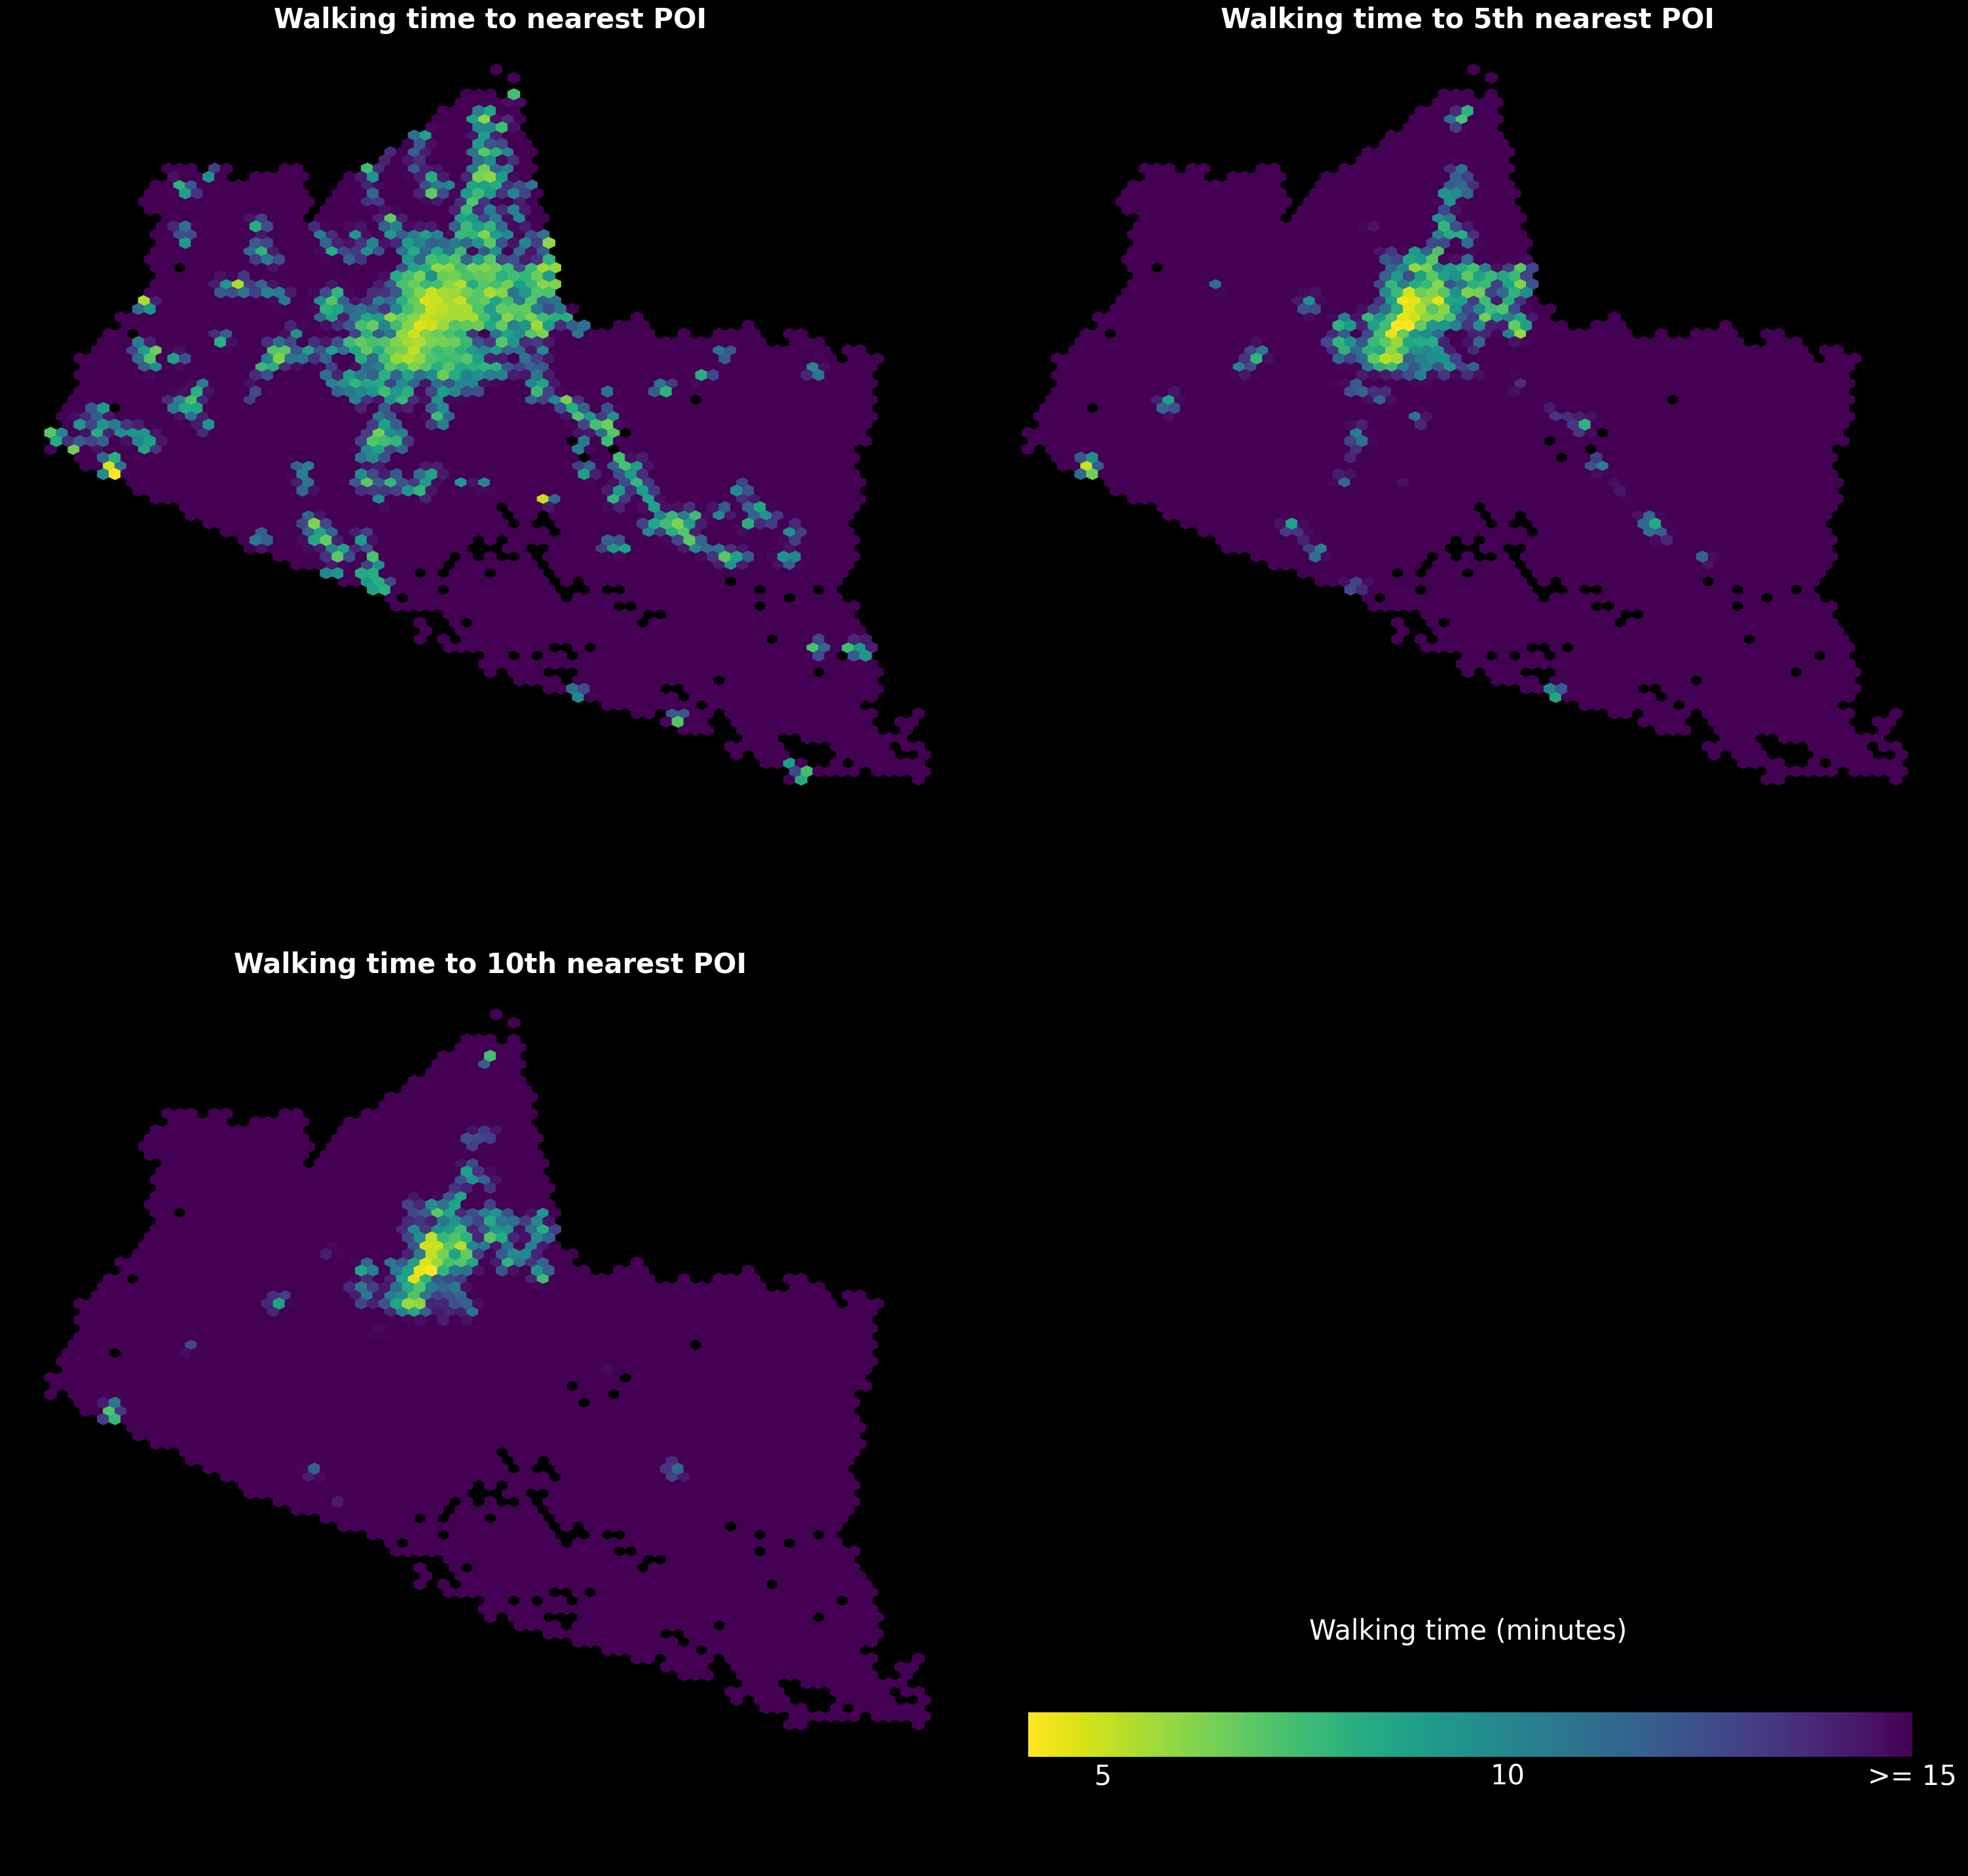

In [10]:
# Setup plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,30), constrained_layout=False)
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[1][0].set_aspect('equal')

# Specify colors
fig.set_facecolor('black')
cmap = 'viridis_r'

# Plot distance to nearest POI
hb = ax[0][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[1],
    alpha=1
)

# Plot distance to 5th nearest POI
hb = ax[0][1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[5],
    alpha=1
)

# Plot distance to 10th nearest POI
hb = ax[1][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[10],
    alpha=1
)

# Add titles to maps
ax[0][0].set_title('Walking time to nearest POI', fontsize=30, fontweight='bold')
ax[0][1].set_title('Walking time to 5th nearest POI', fontsize=30, fontweight='bold')
ax[1][0].set_title('Walking time to 10th nearest POI', fontsize=30, fontweight='bold')

# Setup color bar axis (location of color bar)
cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
cbar_ax.set_axis_off()

# Color bar properties
cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.9,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=20
)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])

# Title for color bar
ax[1][1].text(0.5, 0.23, 'Walking time (minutes)', fontsize=30, ha='center')

# Tight layout
plt.tight_layout()

# Save
# plt.savefig('./docs/walk_access_comparison.png')

In [11]:
# check data
distances.head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
275838150,147.800003,332.799988,662.599976,810.599976,900.0,900.0,900.0,900.0,900.0,900.0
7357532847,59.299999,421.299988,574.099976,722.099976,900.0,900.0,900.0,900.0,900.0,900.0
6811507285,162.399994,318.200012,677.200012,825.200012,900.0,900.0,900.0,900.0,900.0,900.0
8477877404,398.899994,583.900024,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0,900.0
275838539,900.000000,900.000000,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0,900.0


In [12]:
nodes.head()

,x,y
osmid,,
275838150,458717.701207,9.117246e+06
7357532847,458616.558109,9.117291e+06
6811507285,458734.294125,9.117238e+06
8477877404,458664.750111,9.116940e+06
275838539,471892.207142,9.113403e+06


In [13]:
# Get nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=4326)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

In [14]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [15]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
275838150,110.625400,-7.985865,147.800003,332.799988,662.599976,810.599976,900.0,900.0,900.0,900.0,900.0,900.0
7357532847,110.624483,-7.985460,59.299999,421.299988,574.099976,722.099976,900.0,900.0,900.0,900.0,900.0,900.0
6811507285,110.625551,-7.985935,162.399994,318.200012,677.200012,825.200012,900.0,900.0,900.0,900.0,900.0,900.0
8477877404,110.624917,-7.988630,398.899994,583.900024,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0,900.0
6811501975,110.623870,-7.985184,0.000000,480.600006,514.799988,662.799988,900.0,900.0,900.0,900.0,900.0,900.0


In [16]:
# Save as CSV
walk_access_wgs.to_csv('walk_access.csv', encoding='utf-8')

In [18]:
# Save as CSV
walk_access.to_csv('walk_access_utm.csv', encoding='utf-8')

In [17]:
# save the network
ox.save_graph_geopackage(graph_wgs, filepath="Yogyakarta_network.gpkg")